# Transfer Learning in Computer Vision

This assignment lets you explore the techniques of transfer learning and fine tuning, whereby you can
leverage, in large part, the model architecture and expensively trained weights of a large vision
model.  If you don't have all the time, money, GPUs, electricity and training data in the world,
doing so can be a powerful way to quickly get respectable results on a vision problem of your own
without having to raise VC money.

## Introduction

Before getting started, you might want to review our coverage of transfer learning
from class.  In transfer learning, we take a model that was trained on one dataset
and try to re-use some of its learned weights, which correspond to learned features,
on a new, but hopefully somewhat similar problem.  The more similar our new problem is,
the more of the pre-trained model we can probably use, at the lowest expenditure of
effort.  There are many reasons we might resort to transfer learning.  First, large
vision models are often very expensive to train, even when we're confident we have
a good model architecture.  Second, laying hands on good quality, large datasets 
against which to train and validate, can be expensive.  Indeed, you should always be
a bit wary of the generalizability of reported deep learning results in computer
vision because certain datasets get used so heavily.

If you're limited on training resources or training budget, and you don't have
enormous datasets for your problem, transfer learning, in one or more of its forms,
might be a viable option for you.

## The Transfer Learning Workflow

Recall the transfer learning workflow.

First, we borrow the layers from a previously trained model.  The Keras framework,
in the `applications` module, includes a variety of the popular and effective
architectures from the last several years, including the weights they learned
when trained against datasets like ImageNet 1000.  Recall that earlier layers
in a convolutional neural net learn more basic or primitive features, and that
the spatial hierarchies we build up as we proceed deeper in the network, doing
more convolutions, deepening our feature/channel depth by choosing how many
filters to apply and sometimes using $1\times 1$ convolutions to adjust channel
depths for convenience, then aggregate those features into larger more abstract
features, before we flatten the final results and feed them into a classic,
fully connected network.

In transfer learning we _freeze_ the parameters from as many early layers as seem
to work well for our problem.  Then we add some new trainable layers to the deep
end of the network, typically replacing the entire fully connected layer.  Next,
with the layers corresponding to those early, primitive features frozen, we train
the new network on our dataset.  We may also do data augmentation to make up for 
the paucity of our training set.

Finally, once we've obtained decent performance, we can unfreeze all of the model's
parameters and re-run the training process on our new training set but with a very
low learning rate.  Thus we might slightly modify the weights for those previously
frozen features' parameters to better suit our current application.  Choosing a small
learning rate, perhaps 100 or 1000 times smaller than what we'd normally use,
should result in gentler updates to the weights, and not destroy whatever value
they'd donated to us.  Naturally, we should be very mindful of potential
overfitting at this stage.

## The Dataset for This Exercise

We'll use the dataset from the Kaggle cats and dogs classification challenge.  We
might expect this to be a pretty easy task for transfer learning, since the
ImageNet challenge that the network we're going to exploit had had many types of
cats and dogs in its training set, so we might expect even fairly high level
features from fairly deep in the network to still have bearing on our new
problem.

## The Usual Imports

In [1]:
# Our usual cavalcade of imports...
import tensorflow as tf
import keras

import numpy as np

## Transfer Learning and the Kaggle Cats vs. Dogs Dataset

To begin with, we'll have to obtain the dataset.  TensorFlow has its own collection of
datasets, much like Keras does, but it's distributed as an extra package.

In the repaired Azure DSVM environment that you're now using for your class work,
run the command:
```
conda install -c conda-forge tensorflow-datasets
```
The above command will install the datasets into your Conda environment making them pretty convenient
to use.

Once you've installed the above package you'll be ready to massage the data and get
started.

Recall that we often resort to transfer learning when we don't have much training data.
To simulate that circumstance, and also to make your notebooks run fast, we'll only
use about half of the full cats and dogs dataset.  The dataset contains 25,000 images
in its entirety, so we'll take 40% of them for training, 10% for cross-validation and
10% for a final test set.

### Set Up Train, Validation and Test Sets

In [2]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# HINT: Now might be a time to open the TensorFlow Dataset
#       documentation and keep it handy in a window. We've
#       paid it lip service in class, but not covered it in
#       a disciplined way, and it's really a thing you should
#       get acquainted with for reasons that the documentation
#       might convince you of: 
#
#       https://www.tensorflow.org/api_docs/python/tf/data/Dataset
#
train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
                                             # Reserve 10% for validation and 10% for test
                                             split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
                                             as_supervised=True,  # Include labels
)

print(f"Training set samples:   {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation set samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Test set samples:       {tf.data.experimental.cardinality(test_ds)}")

/anaconda/envs/narkal-tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training set samples:   9305
Validation set samples: 2326
Test set samples:       2326


### Visualize Some of the Training Samples

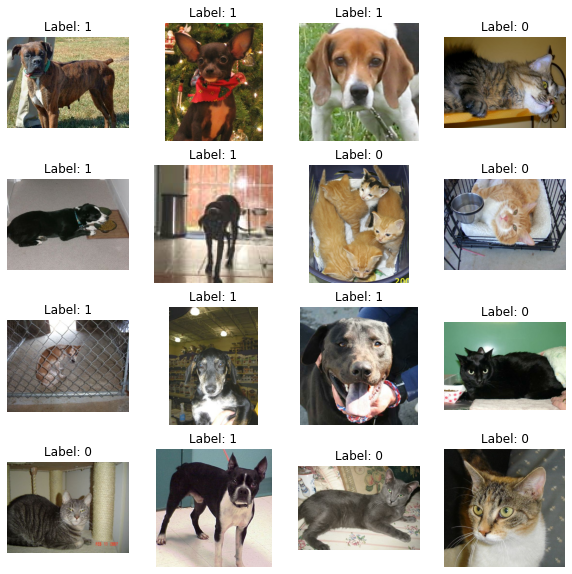

In [3]:
import matplotlib.pyplot as plt

# Here we get to cut and paste our way to glory with the
# matplotlib API!  Helpful tip: in real life work, the
# sort of stuff below is the kind of thing you really
# want to put in a library function of your own devising,
# and your own documentation, with suitable arguments to
# make it flexible enough for reasonably general re-use,
# so you don't have to type this sort of stuff every time,
# remember what's offset-1 from MATLAB, what's still offset-0
# from Python, etc.
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {int(label)}")
    plt.axis("off")

### How's the Data Look?

Note that the sizes and aspect ratios of the images vary all over the map,
whereas IIRC the dataset we played with in class was either uniformly sized,
or we forced it be so early enough in the exercise that we could stop
thinking about it.  Also note what the assigned class labels seem to be.

### Data Standardization

Before feeding a convolutional neural network, we often have to do some kind of standardization
to present the network what it was originally designed to see.  Typically the things we'd
worry about at this point would be image height and width, channel depth, potentially ordering
of the channels (remember OpenCV uses BGR instead of RGB and there's lots of stuff floating
around that's been touched by OpenCV at some point, and this can lead to some wonky colors
when we're not expecting it), and very often also mean-shifting and variance scaling the
ranges of the color channel values.  You'll always want to look at the specifics of whichever
model your transfer learning efforts are cannibalizing to make sure you don't misfeed it
and produce strange results.

We'll bake the necessary standardization and preprocessing into our data pipeline for convenience.
In some applications, you might have reason to do this independently, but if you do, you'll have
to keep track of what needs to be done, when it's done, and how it was done so you don't end up
stepping on your own feet, sometimes dealing with preprocessed data, and sometimes not, and getting
weird and unpredictable results.

In [4]:
size = (150, 150)

# NOTE: On of the things the Dataset abstraction provides is the ability to
#       'map' a function on to the examples in the dataset, which results
#       in returning a new dataset with the operation applied.  If the type
#       of dataset you're loading is one that loads data in batches from disk,
#       for example, the map will be applied lazily, when the relevant data
#       is actually called for.  Also, for functional style operators like map,
#       the processing can be parallelized across multiple CPU cores, thus
#       speeding things up and keeping your hardware better utilized.
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
# NOTE: Datasets also handle batching your data for you automatically.
# And they can cache or prefetch information.  You might want to 
# look up the documentation for `batch` and `prefetch` and `cache`
# below to familiarize yourself with them before you move on from this
# cell too quickly.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Data Augmentation

Recall the discussion of data augmentation from class.  We can often stretch a meager dataset
further in a vision application by randomly transforming training examples each time they're
presented during a training epoch, so the model is sort of seeing more examples.  As we
discussed in class, you don't want to go too nuts with it.  You should fill in the
augmentation layer below using the sorts of things we did in class (and I encourage you to
look at the documentation on Keras's _Image augmentation layers_ and see what options are 
available to you!).

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        # TODO: Add some random transformations for image augmentation
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal")
    ]
)

#### Visualizing the Data Augmentation Effects

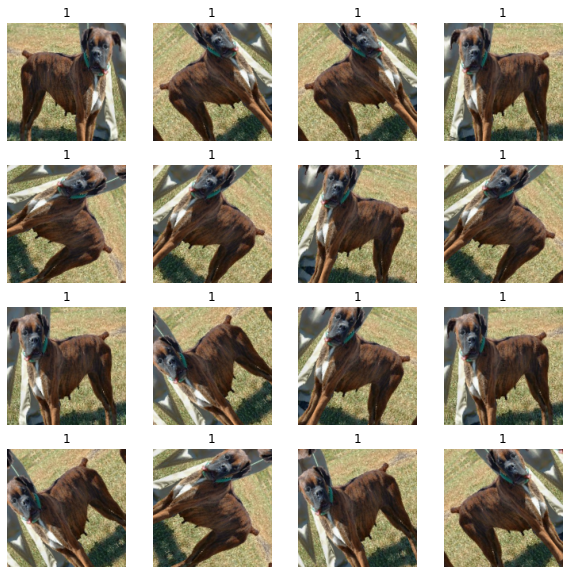

In [7]:
import numpy as np

# Huh, interesting, this easy to get wrong code is so similar to the
# stuff above that it really begs to be pulled out into a helper
# function that you can carry along with you in your toolbox rather
# than having to cut and paste, debug, or play guess what color the
# API designer was thinking, every time you use it.
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Build Your New Model Atop the Convolutional Front-End of Xception

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [8]:
# TODO: Create an instance of the Xception network from the keras.applications
# module, and configure it to use the "imagenet" pre-trained weights, the
# input shape from above and channel depth of 3, and make sure to *not*
# include the fully connected end stages of the network, as we discussed
# in class.
shape = (150,150,3)
base_model = keras.applications.Xception(include_top=False, weights="imagenet", input_shape=shape)

# TODO: Freeze the weights in the convolutional base you extracted above
base_model.trainable = False

# From here forward, use the Keras Functional API to wire things together...

# TODO: Create a Keras Input object with the height, width and channel depth of your inputs
inputs = keras.Input(shape=shape)

# TODO: Apply your data augmentation layer to the Input you created
x = data_augmentation(inputs) # Apply random data augmentation

# The pre-trained Xception weights expect that the input is scaled
# from the original (0, 255) range into a range of (-1., +1.).
# The Rescaling layer you add below should normalize the (0,255)
# range into (-1, 1) by setting the appopriate scale and offset values.
# TODO: Configure the Rescaling layer
rescaling_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = rescaling_layer(x)

# The convolutional base contains some Batch Normalization layers.
# We've mentioned these in class a few times, but have so far deferred
# our discussion of their details.  For the purpose of this exercise,
# we wantn to keep those layers in "inference mode" when we unfreeze the 
# base model for fine-tuning.  Thus make sure the base model is running
# in inference mode and not training mode here...
#
# If you want to read more about this, here's a small chunk on it
# in the Keras docs that you may want to consult.  Note that Batch
# Normalization, like Dropout requires some special treatment,
# and the prevailing wisdom on Batch Normalization is in some ways
# not quite even settled:
#
# https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute
#
# Observe that there's a slightly sneaky exception for the Batch
# Normalization layer type. Again, we'll talk more about just what
# those layers are for later, but for now put a sticky note in your
# mind that when you encounter them you need to tread lightly and
# think a bit more carefully until you're used to the peculiarities.
#
x = base_model(x, training=False) # TODO: Put convolutional base in inference mode

# Our new fully connected end...
x = keras.layers.GlobalAveragePooling2D()(x) 
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x) # Binary classifer 0/1 cat vs. dog
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

### Train Your New Fully Connected Top Layer

Now we'll train the network that we've built out of the convolutional base borrowed
from Xception trained on ImageNet with your new fully connected layer grafted on to
the end.

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 281s 953ms/step - loss: 0.2283 - binary_accuracy: 0.8965 - val_loss: 0.0888 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 273s 937ms/step - loss: 0.1710 - binary_accuracy: 0.9258 - val_loss: 0.0809 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 273s 938ms/step - loss: 0.1605 - binary_accuracy: 0.9293 - val_loss: 0.0774 - val_binary_accuracy: 0.9673
Epoch 4/20
291/291 [==============================] - 267s 917ms/step - loss: 0.1602 - binary_accuracy: 0.9324 - val_loss: 0.0755 - val_binary_accuracy: 0.9721
Epoch 5/20
291/291 [==============================] - 268s 923ms/step - loss: 0.1514 - binary_accuracy: 0.9338 - val_loss: 0.0745 - val_binary_accuracy: 0.9690
Epoch 6/20
291/291 [==============================] - 268s 921ms/step - loss: 0.1470 - binary_accuracy: 0.9369 - val_loss: 0.0838 - val_binary_accuracy: 0.9656
Epoch 7/20
291/291 [====================

### Fine Tuning

Now might be a good time to consult the flow chart on transfer learning that you can
find in the lecture slides, to take in a broad view of the process we've been going
through in this exercise.

Read them over, along with your notes, and make sure you feel like you have a good
sense and intuition for just what we've been doing, and why, and above all, why we
might expect it to work, and where we might want to be careful.  Then proceed with
wrapping up the assignment by _fine-tuning_ your new model.

To fine tune your model, let's unfreeze the base model and re-train the entire model end-to-end
with a low learning rate. The idea here is that although we got a good model by re-using the
weights in the convolutional base, verbatim, maybe we can do better if we allow those weights
to adjust a little bit to better conform to our new dataset.  Obviously we want the training
process to proceed kind of gingerly here, since if we've reached the point where we're
considering fine tuning, we don't want to throw our pre-trained babies out with our instatiable
greed for half a percent of additional accuracy bathwater.

Also, recall the admonition in the comments above.  Although we're going to make the convolutional base 
trainable, it is still running in inference mode since we passed `training=False` when calling it
during model construction.  Thus, batch normalization layers inside the convolutional base
won't update their batch statistics. If we let those layers do so, they could really destroy
the representations the model has already learned and, if we're at this point, we presumably value
those enough to not ruin them.

In [10]:
# TODO: Unfreeze the base_model.
# Mind the remark in the text cell above about training mode vs.
# inference mode and the batch normalization layers
base_model.trainable = True # TODO: Unfreeze the convolutional base
model.summary() # NOTE: You might want to contrast the parameter counts here vs. earlier

model.compile(
    optimizer=keras.optimizers.Adam(0.00001),  # TODO: Try a small learning rate like 10^-5                                            
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# NOTE: After you've trained successfully with 10^-5, you might want to try 10^-4 and
#       see if things get appreciably worse.  Remember, small learning rates will slow
#       training, so as always there's a tradeoff to be sought here between training
#       speed and training quality, but now there's an extra dimension here of not
#       screwing up the pre-trained weights, whose value is what motivated this
#       whole strategy in the first place.

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

### Final Assessment

__QUESTION:__ What was the final performance of the model like compared to that of what we had before
the fine-tuning process?

Note that we trained for only 10 epochs, fewer than we original trained for, and we
used a pretty puny learning rate.  Remember, in fine-tuning, we want to be gentle,
so we don't wreck the valuable parts of what we're trying to improve.

_ANSWER:_ TODO, your answer here on how much of a difference, if any, you observed with fine tuning.

Training loss decreased by a factor of 10, training accuracy by +5%,  validation loss and accuracy didn't increase by as much as training metrics did but still showed significant improvement.